In [1]:
!pip install wikipedia
# !pip install spacy -q
# !python -m spacy download en_core_web_sm -q

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=761d12aa2826498db2ff2fd3d7a487bee225e6e917636503a6a4f9e51b54726a
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [2]:
import numpy as np
import wikipedia

In [3]:
import numpy as np
## import wiki libaries
from tqdm import tqdm
import wikipedia

Data = wikipedia.page("Natural language generation").content
docs = wikipedia.search("Natural Language Processing", results=3)
for doc in tqdm(docs):
    try:
        Data = Data + wikipedia.page(doc).content
    except:
        print("Error in ", doc)
        continue

100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


In [4]:
DBACKUP = Data

In [40]:
# Data = DBACKUP

In [41]:
Data = Data.split(".")
print("Number of sentences = ", len(Data))

Number of sentences =  793


In [42]:
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# Load spaCy English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Download NLTK data
nltk.download("punkt")
nltk.download("stopwords")

# Tokenization and preprocessing
def preprocess(doc):
    # Tokenize using NLTK
    tokens = word_tokenize(doc)

    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    filtered_tokens = [word for word in filtered_tokens if len(word) > 1]

    # Create a spaCy document for lemmatization
    spacy_doc = nlp(' '.join(filtered_tokens))

    # Lemmatization using spaCy
    lemmatized_tokens = [token.lemma_ for token in spacy_doc]
    
    return lemmatized_tokens

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
Data = [preprocess(sentence) for sentence in Data]

In [44]:
## visualize processed Data
print(Data[1])

['survey', 'nlg', 'method', 'describe', 'nlg', 'subfield', 'artificial', 'intelligence', 'computational', 'linguistic', 'concerned', 'construction', 'computer', 'system', 'produce', 'understandable', 'text', 'english', 'human', 'language', 'underlie', 'representation', 'information']


In [45]:
Data = [' '.join(sample) for sample in Data]

In [46]:
Data[1]

'survey nlg method describe nlg subfield artificial intelligence computational linguistic concerned construction computer system produce understandable text english human language underlie representation information'

In [47]:
GROUP_SIZE = 20 ## OR INPUT SIZE + 1 , GROUP_SIZE - 1 Input tokens / Final Letter used as GT

In [48]:
Data = [x for x in Data if len(x) > GROUP_SIZE]
len(Data)

659

In [49]:
print(Data[0])
print(Data[1])

natural language generation nlg software process produce natural language output
survey nlg method describe nlg subfield artificial intelligence computational linguistic concerned construction computer system produce understandable text english human language underlie representation information


In [50]:
sliding_window = []
for sentence in Data:
    for i in range(max(len(sentence)-GROUP_SIZE, 0)):
        sliding_window.append(sentence[i:i+GROUP_SIZE])

In [51]:
DataGroup = [list(sample) for sample in sliding_window]
len(DataGroup)

54873

In [52]:
## shuffle the data
np.random.shuffle(DataGroup)

## sample only a part of the full data to save computation
DataGroup = DataGroup[:len(DataGroup)//3] 

## train / test split
X_train = DataGroup[:int(0.8*len(DataGroup))]
X_test = DataGroup[int(0.8*len(DataGroup)):]

In [53]:
print("Number of training samples = ", len(X_train))
print("Number of testing samples = ", len(X_test))

Number of training samples =  14632
Number of testing samples =  3659


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, unique):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        ## multi-layer RNN
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True, nonlinearity="relu", num_layers=2, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.embedding_layer = nn.Embedding(unique, embedding_dim)
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        x = self.embedding_layer(x)
        # print(x.shape)
        # Forward propagate the RNN
        out, hn = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


In [55]:
train_flattened = [item for sublist in X_train for item in sublist]

In [56]:
unique_letters = list(set(list(" ".join(train_flattened))))
unique_letters.append("UNK")
unique_letters.append("PAD")
letter_to_idx = {letter: i for i, letter in enumerate(unique_letters)}
idx_to_letter = {i: letter for i, letter in enumerate(unique_letters)}

In [57]:
X_train = [[letter_to_idx[letter] for word in sentence for letter in word] for sentence in X_train]
print(X_train[0])

[4, 23, 21, 25, 5, 23, 12, 18, 5, 7, 21, 7, 5, 25, 3, 12, 5, 3, 20, 21]


In [58]:
X_temp = [[] for _ in range(len(X_test))]
for i, sentence in enumerate(X_test):
        for k, letter in enumerate(sentence):
            if letter in unique_letters:
                X_temp[i].append(unique_letters.index(letter))
            else:
                X_temp[i].append(unique_letters.index("UNK"))
                
print(X_temp[0])
X_test = X_temp

[23, 28, 11, 5, 23, 28, 17, 25, 21, 5, 25, 17, 23, 1, 20, 18, 21, 23, 20, 9]


In [59]:
## create custom dataset class

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, train=True):
        self.X = X
        self.train = train
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx][:-1], dtype=torch.int)
        y = torch.tensor(self.X[idx][-1], dtype=torch.int)
        ## randomly mask a random number of words in the sentence
        num_letters = len(X)
        ## gaussian distribution of number of words to mask with mean equal to 1/5th of the number of letters
        if(self.train):
            num_mask = int(np.random.normal(num_letters//5, 1))
            num_mask = max(1, num_mask)
            mask = np.random.choice(num_letters, num_mask, replace=False)
            X[mask] = unique_letters.index("UNK")

        X = X.to(device)
        y = y.to(device)
        return X, y
        

In [60]:
device = 'cuda'

X_trainset = CustomDataset(X_train)
X_testset = CustomDataset(X_test, train=False)

train_loader = torch.utils.data.DataLoader(X_trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_testset, batch_size=32, shuffle=False)

## Architecture 1

In [61]:
word_model = SimpleRNN(hidden_size=2048, output_size=len(unique_letters), embedding_dim=128, unique=len(unique_letters))
word_model = word_model.to(device)

In [62]:
word_model

SimpleRNN(
  (rnn): RNN(128, 2048, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=2048, out_features=32, bias=True)
  (embedding_layer): Embedding(32, 128)
)

### Train Function

In [64]:
from IPython.display import clear_output
from tqdm import tqdm 
import matplotlib.pyplot as plt

def train_model(word_model):
    
    ## define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(word_model.parameters(), lr=0.0001)
    # Check if GPU is available and set device accordingly
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    ## train the model

    num_epochs = 20
    training_losses = []
    test_losses = []
    for epoch in tqdm(range(num_epochs)):
        word_model.train()
        train_loss = 0
        for i, (X, y) in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            y_pred = word_model(X)
            loss = criterion(y_pred, y.long())
            train_loss += loss.item()
            # print(torch.argmax(y_pred, dim=1), y)
            loss.backward()
            optimizer.step()

        train_loss = train_loss/len(train_loader)
        training_losses.append(train_loss)



        ## calculate loss and accuracy on the test set and save it for plotting
        word_model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in tqdm(test_loader):
                y_pred = word_model(X)
                loss = criterion(y_pred, y.long())
                test_loss += loss.item()
                total += y.size(0)
                correct += (torch.argmax(y_pred, dim=1) == y).sum().item()

        test_loss = test_loss/len(test_loader)
        test_losses.append(test_loss)
        clear_output(wait=True)
        ## print the loss after each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {correct/total:.4f}")
        ## visualize the test accuracy and training loss
        plt.figure(figsize=(10, 5))
        plt.plot(training_losses, label="Training Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()



Epoch [20/20], Loss: 0.6636
Test Loss: 2.0228, Test Accuracy: 0.5690


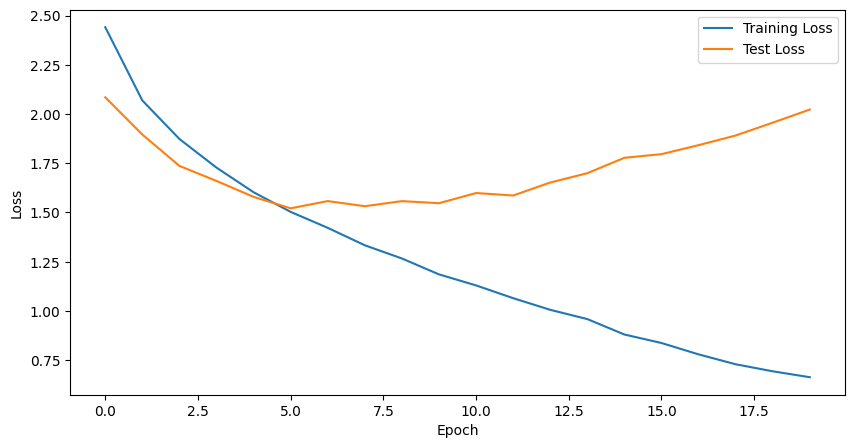

100%|██████████| 20/20 [02:54<00:00,  8.74s/it]


In [65]:
train_model(word_model)

### Generation Evaluation

In [66]:
def get_next_letter(pt_sentence, model):
    idx = torch.argmax(model(pt_sentence.unsqueeze(0)), dim=1)
    letter = idx_to_letter[idx.item()]
#     print("letter", letter)
    return idx, letter

def get_next_n(pt_sentence, n, model):
    generated_ids = []
    for i in range(n):
        next_id, letter = get_next_letter(pt_sentence, model)
        generated_ids.append(next_id.item())
        pt_sentence = torch.concatenate([pt_sentence[1:], next_id])
    return generated_ids

def complete_n(dataset, n_samples, length, model, marker=" (gen) "):
    dtrain = dataset.train
    dataset.train = False

    for i in range(n_samples):
        sample_num = np.random.randint(0, len(dataset))
        base = dataset[sample_num][0]
        decoded_base = ''.join([idx_to_letter[x.item()] for x in base])
        
        generated = get_next_n(base, length, model)
        decoded_gen = ''.join([idx_to_letter[x] for x in generated])
        
    
        print(f"SAMPLE {i+1}:", decoded_base + marker + decoded_gen)
        print("="*30)
        
    dataset.train = dtrain
    
def quick_analyze(model, n_samples=5, length=50):
    print("TRAIN SET DATA")
    print("|"* 100)
    complete_n(X_trainset, n_samples=n_samples, length=length, model=model)
    print("|"* 100)
    print("TEST SET DATA")
    print("|"* 100)
    complete_n(X_trainset, n_samples=n_samples, length=length, model=model)

In [67]:
quick_analyze(word_model)

TRAIN SET DATA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SAMPLE 1: cally operationaliz (gen) ation include summary tert book fligunation exhers
SAMPLE 2: rstand history opti (gen) cal chapase structure phearity twintially separate
SAMPLE 3: word search query k (gen) eework signining document first anthology extracti
SAMPLE 4: input nlg system ne (gen) ed compect outling determine torage concept dereva
SAMPLE 5: m name entity recog (gen) nition system information aid compound term proces
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST SET DATA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SAMPLE 1: ultuous search arti (gen) ficial intelligence research arigina type speech r
SAMPLE 2: rea nlp evaluation  (gen) grammar sfferate use disticulate spart language su
SAMPLE 3:  natural language g (gen) eneration sixty investi

### Architecture 2 (smaller model)

In [68]:
word_model2 = SimpleRNN(hidden_size=512, output_size=len(unique_letters), embedding_dim=64, unique=len(unique_letters))
word_model2 = word_model2.to(device)

In [69]:
word_model2

SimpleRNN(
  (rnn): RNN(64, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=32, bias=True)
  (embedding_layer): Embedding(32, 64)
)

Epoch [20/20], Loss: 1.3960
Test Loss: 1.6344, Test Accuracy: 0.5354


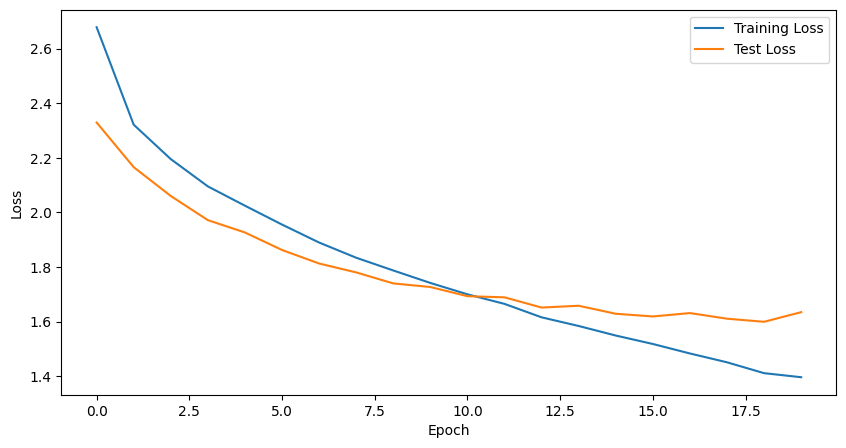

100%|██████████| 20/20 [01:25<00:00,  4.28s/it]


In [70]:
train_model(word_model2)

### Generation Evaluation

In [71]:
quick_analyze(word_model2)

TRAIN SET DATA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SAMPLE 1: ly human community  (gen) expression subter desermine text sentence also cor
SAMPLE 2: t loebner prize win (gen) ner machine translation mate textual methor expres
SAMPLE 3: s individual word c (gen) ontext sentence also corpora speech recognition su
SAMPLE 4: us search artificia (gen) l intertation summary context sentence also corpor
SAMPLE 5: isle far northeast  (gen) corpora speech recognition subully sentence also c
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST SET DATA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SAMPLE 1: elopmental trajecto (gen) ry natural language context sentence also corpora 
SAMPLE 2:  refer front door j (gen) ollog sentence basign semantic relationship active
SAMPLE 3: egmentation signifi (gen) cation summary context 

## Architecture 3 (LSTM)

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, unique):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        # Multi-layer LSTM
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.embedding_layer = nn.Embedding(unique, embedding_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        # Embedding layer
        x = self.embedding_layer(x)
        # Forward propagate the LSTM
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [73]:
word_model3 = SimpleLSTM(hidden_size=1024, output_size=len(unique_letters), embedding_dim=128, unique=len(unique_letters))
word_model3 = word_model3.to(device)

In [74]:
word_model3

SimpleLSTM(
  (rnn): LSTM(128, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=32, bias=True)
  (embedding_layer): Embedding(32, 128)
  (sigmoid): Sigmoid()
)

Epoch [20/20], Loss: 0.7697
Test Loss: 1.6002, Test Accuracy: 0.5758


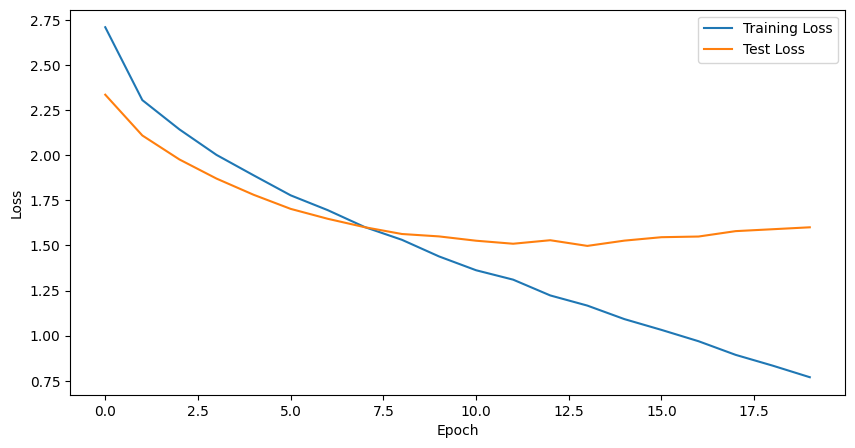

100%|██████████| 20/20 [02:58<00:00,  8.95s/it]


In [75]:
train_model(word_model3)

### Generation Eval

In [76]:
quick_analyze(word_model3)

TRAIN SET DATA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SAMPLE 1: relate area nlg app (gen) lication commary computational linguistic contract
SAMPLE 2:  language construct (gen)  real world semantic part speech recognition syste
SAMPLE 3: ing prescriptive as (gen) sociation system information aist comparison analy
SAMPLE 4: esign recognize dep (gen) ent contration also computational linguistic contr
SAMPLE 5: tity link many prop (gen) erse search paral resparch paral resparch paral re
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST SET DATA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
SAMPLE 1:  neural network han (gen) d rever also consist semantic relationship inversi
SAMPLE 2: age assessment asse (gen) ssmant construct real world semantic part speech r
SAMPLE 3: ess use repetition  (gen) compary text system inf